<a href="https://colab.research.google.com/github/NolanRink/CS4540/blob/main/HW12/Copy_of_Trees%2C_RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# In Depth: Decision Trees and Random Forests

Previously we have looked in depth at a simple generative classifier (naive Bayes; see [In Depth: Naive Bayes Classification](05.05-Naive-Bayes.ipynb)) and a powerful discriminative classifier (support vector machines; see [In-Depth: Support Vector Machines](05.07-Support-Vector-Machines.ipynb)).
Here we'll take a look at another powerful algorithm: a nonparametric algorithm called *random forests*.
Random forests are an example of an *ensemble* method, meaning one that relies on aggregating the results of a set of simpler estimators.
The somewhat surprising result with such ensemble methods is that the sum can be greater than the parts: that is, the predictive accuracy of a majority vote among a number of estimators can end up being better than that of any of the individual estimators doing the voting!
We will see examples of this in the following sections.

We begin with the standard imports:

In [46]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Motivating Random Forests: Decision Trees

Random forests are an example of an ensemble learner built on decision trees.
For this reason, we'll start by discussing decision trees themselves.

Decision trees are extremely intuitive ways to classify or label objects: you simply ask a series of questions designed to zero in on the classification.
For example, if you wanted to build a decision tree to classify animals you come across while on a hike, you might construct the one shown in the following figure.

![](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/images/05.08-decision-tree.png?raw=1)
[figure source in Appendix](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/06.00-Figure-Code.ipynb#Decision-Tree-Example)

The binary splitting makes this extremely efficient: in a well-constructed tree, each question will cut the number of options by approximately half, very quickly narrowing the options even among a large number of classes.
The trick, of course, comes in deciding which questions to ask at each step.
In machine learning implementations of decision trees, the questions generally take the form of axis-aligned splits in the data: that is, each node in the tree splits the data into two groups using a cutoff value within one of the features.
Let's now look at an example of this.

### Creating a Decision Tree

Consider the following two-dimensional data, which has one of four class labels (see the following figure):

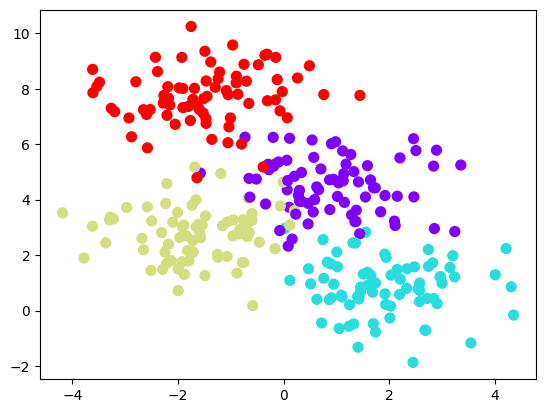

In [47]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

A simple decision tree built on this data will iteratively split the data along one or the other axis according to some quantitative criterion, and at each level assign the label of the new region according to a majority vote of points within it.
The following figure presents a visualization of the first four levels of a decision tree classifier for this data.

![](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/images/05.08-decision-tree-levels.png?raw=1)
[figure source in Appendix](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/06.00-Figure-Code.ipynb#Decision-Tree-Levels)

Notice that after the first split, every point in the upper branch remains unchanged, so there is no need to further subdivide this branch.
Except for nodes that contain all of one color, at each level *every* region is again split along one of the two features.

This process of fitting a decision tree to our data can be done in Scikit-Learn with the ``DecisionTreeClassifier`` estimator:

In [48]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier().fit(X, y)

Let's write a utility function to help us visualize the output of the classifier:

In [49]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()

    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

Now we can examine what the decision tree classification looks like (see the following figure):

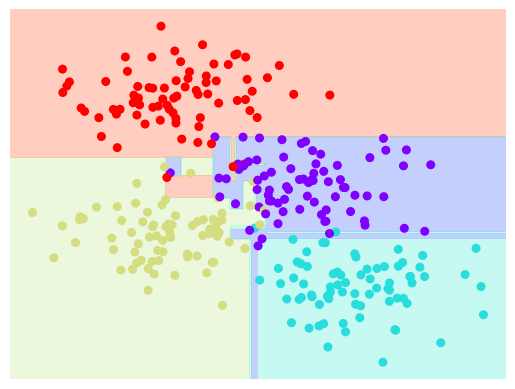

In [50]:
visualize_classifier(DecisionTreeClassifier(), X, y)

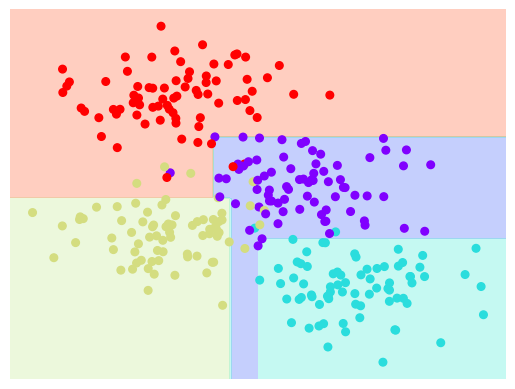

In [51]:
visualize_classifier(DecisionTreeClassifier(max_depth = 4), X, y)

If you're running this notebook live, you can use the helper script included in the online [appendix](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/06.00-Figure-Code.ipynb#Helper-Code) to bring up an interactive visualization of the decision tree building process:

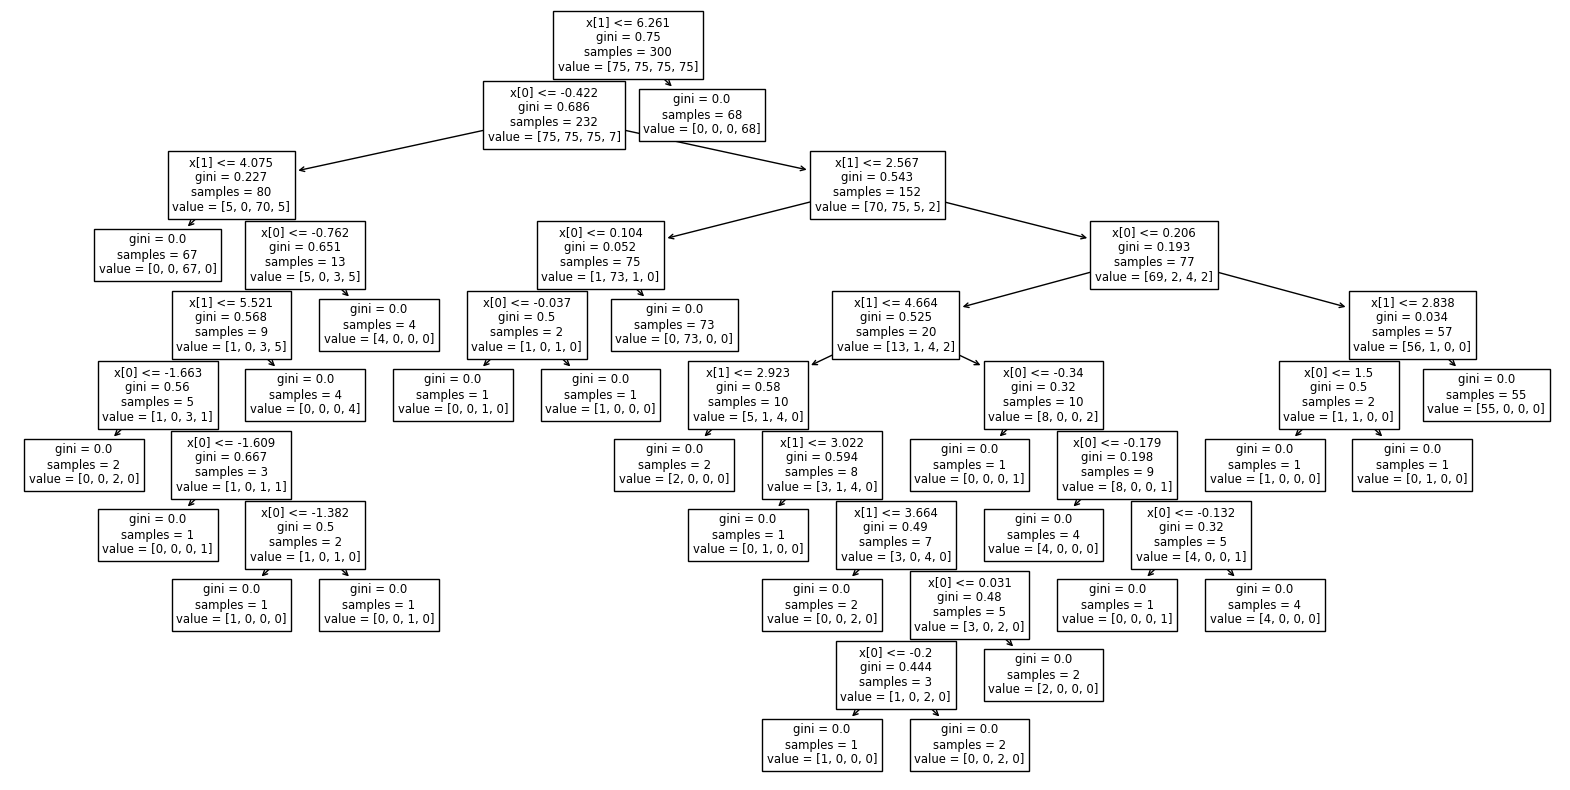

In [52]:
from sklearn.tree import plot_tree
plt.figure(figsize = (20, 10))
plot_tree(tree);

In [53]:
# helpers_05_08 is found in the online appendix
# import helpers_05_08
# helpers_05_08.plot_tree_interactive(X, y);

Notice that as the depth increases, we tend to get very strangely shaped classification regions; for example, at a depth of five, there is a tall and skinny purple region between the yellow and blue regions.
It's clear that this is less a result of the true, intrinsic data distribution, and more a result of the particular sampling or noise properties of the data.
That is, this decision tree, even at only five levels deep, is clearly overfitting our data.

In [54]:
tree.feature_importances_

array([0.34410486, 0.65589514])

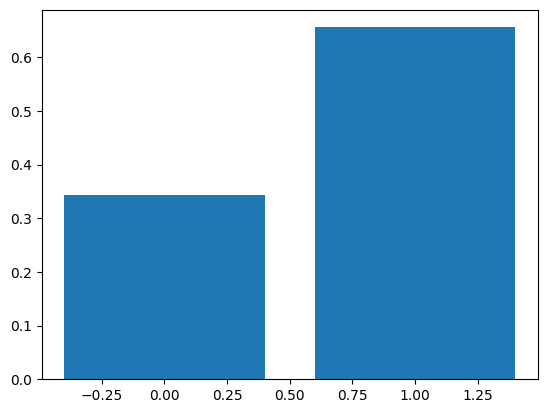

In [55]:
plt.bar([0, 1], tree.feature_importances_);

### Decision Trees and Overfitting

Such overfitting turns out to be a general property of decision trees: it is very easy to go too deep in the tree, and thus to fit details of the particular data rather than the overall properties of the distributions it is drawn from.
Another way to see this overfitting is to look at models trained on different subsets of the data—for example, in this figure we train two different trees, each on half of the original data.

![](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/images/05.08-decision-tree-overfitting.png?raw=1)
[figure source in Appendix](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/06.00-Figure-Code.ipynb#Decision-Tree-Overfitting)

It is clear that in some places the two trees produce consistent results (e.g., in the four corners), while in other places the two trees give very different classifications (e.g., in the regions between any two clusters).
The key observation is that the inconsistencies tend to happen where the classification is less certain, and thus by using information from *both* of these trees, we might come up with a better result!

If you are running this notebook live, the following function will allow you to interactively display the fits of trees trained on a random subset of the data:

In [56]:
# helpers_05_08 is found in the online appendix
# import helpers_05_08
# helpers_05_08.randomized_tree_interactive(X, y)

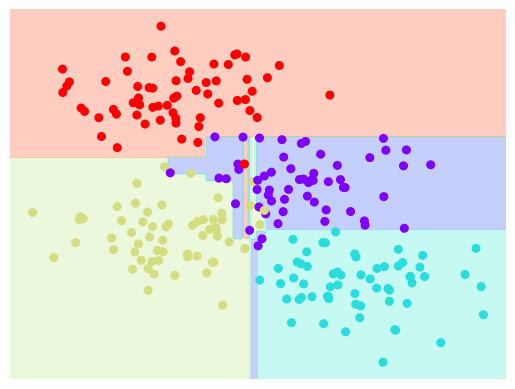

In [57]:
random_inds = np.random.choice(range(len(X)), int(0.8 * len(X)), replace = False)
Xs, ys = X[random_inds], y[random_inds]
visualize_classifier(DecisionTreeClassifier(), Xs, ys)

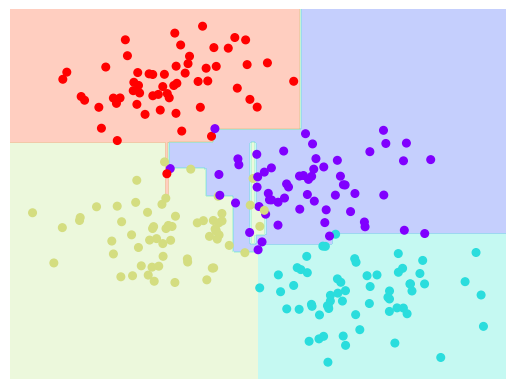

In [58]:
random_inds = np.random.choice(range(len(X)), int(0.8 * len(X)), replace = False)
Xs, ys = X[random_inds], y[random_inds]
visualize_classifier(DecisionTreeClassifier(), Xs, ys)

Just as using information from two trees improves our results, we might expect that using information from many trees would improve our results even further.

## Ensembles of Estimators: Random Forests

This notion—that multiple overfitting estimators can be combined to reduce the effect of this overfitting—is what underlies an ensemble method called *bagging*.
Bagging makes use of an ensemble (a grab bag, perhaps) of parallel estimators, each of which overfits the data, and averages the results to find a better classification.
An ensemble of randomized decision trees is known as a *random forest*.

This type of bagging classification can be done manually using Scikit-Learn's `BaggingClassifier` meta-estimator, as shown here (see the following figure):

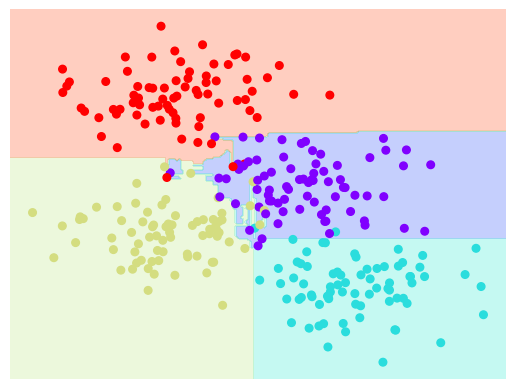

In [59]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8,
                        random_state=1)

bag.fit(X, y)
visualize_classifier(bag, X, y)

In this example, we have randomized the data by fitting each estimator with a random subset of 80% of the training points.
In practice, decision trees are more effectively randomized by injecting some stochasticity in how the splits are chosen: this way all the data contributes to the fit each time, but the results of the fit still have the desired randomness.
For example, when determining which feature to split on, the randomized tree might select from among the top several features.
You can read more technical details about these randomization strategies in the [Scikit-Learn documentation](http://scikit-learn.org/stable/modules/ensemble.html#forest) and references within.

In Scikit-Learn, such an optimized ensemble of randomized decision trees is implemented in the `RandomForestClassifier` estimator, which takes care of all the randomization automatically.
All you need to do is select a number of estimators, and it will very quickly—in parallel, if desired—fit the ensemble of trees (see the following figure):

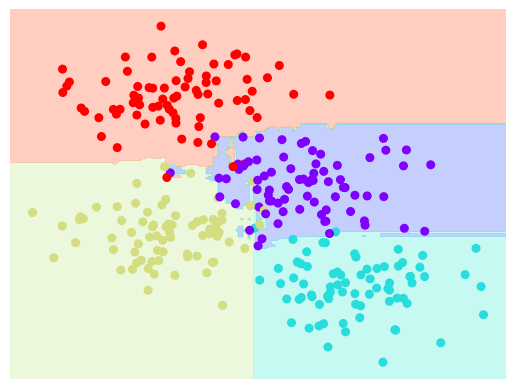

In [60]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=0)
visualize_classifier(model, X, y);

We see that by averaging over 100 randomly perturbed models, we end up with an overall model that is much closer to our intuition about how the parameter space should be split.

## Random Forest Regression

In the previous section we considered random forests within the context of classification.
Random forests can also be made to work in the case of regression (that is, with continuous rather than categorical variables). The estimator to use for this is the `RandomForestRegressor`, and the syntax is very similar to what we saw earlier.

Consider the following data, drawn from the combination of a fast and slow oscillation (see the following figure):

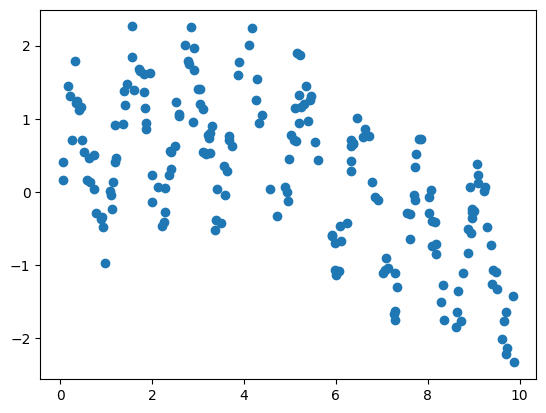

In [61]:
rng = np.random.RandomState(42)
x = 10 * rng.rand(200)

def model(x, sigma=0.3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * rng.randn(len(x))

    return slow_oscillation + fast_oscillation + noise

y = model(x)
plt.scatter(x, y);

Using the random forest regressor, we can find the best-fit curve as follows (see the following figure):

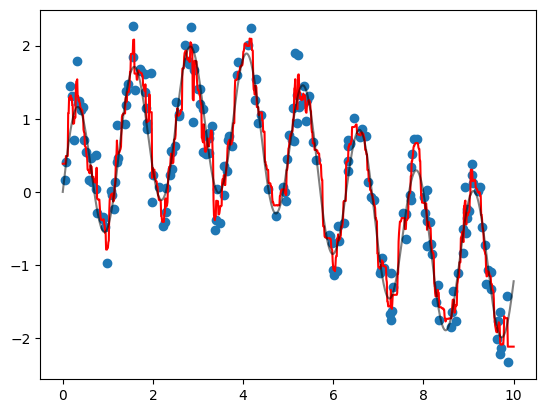

In [62]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(200)
forest.fit(x[:, None], y)

xfit = np.linspace(0, 10, 1000)
yfit = forest.predict(xfit[:, None])
ytrue = model(xfit, sigma=0)

plt.scatter(x, y)
plt.plot(xfit, yfit, '-r');
plt.plot(xfit, ytrue, '-k', alpha=0.5);

Here the true model is shown in the smooth gray curve, while the random forest model is shown by the jagged red curve.
The nonparametric random forest model is flexible enough to fit the multiperiod data, without us needing to specifying a multi-period model!

## Example: Random Forest for Classifying Digits

In Chapter 38 we worked through an example using the digits dataset included with Scikit-Learn.
Let's use that again here to see how the random forest classifier can be applied in this context:

In [63]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

To remind us what we're looking at, we'll visualize the first few data points (see the following figure):

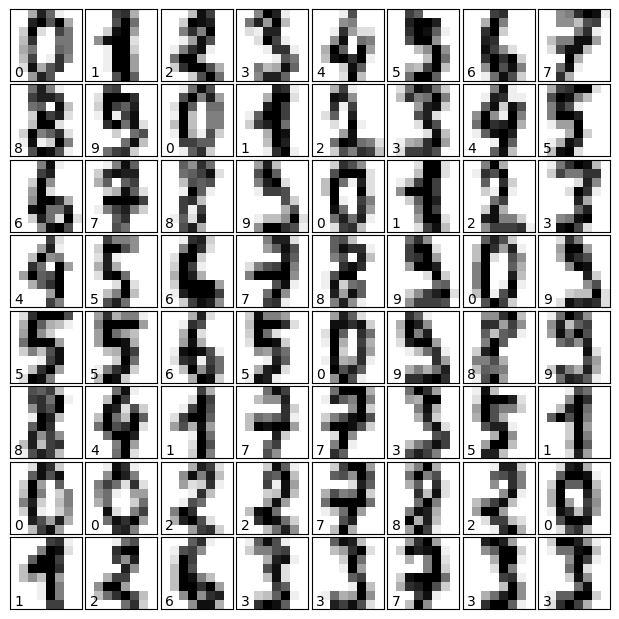

In [64]:
# set up the figure
fig = plt.figure(figsize=(6, 6))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the digits: each image is 8x8 pixels
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')

    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))

We can classify the digits using a random forest as follows:

In [65]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target,
                                                random_state=0)
model = RandomForestClassifier(n_estimators=1000)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

Let's look at the classification report for this classifier:

In [66]:
from sklearn import metrics
print(metrics.classification_report(ypred, ytest))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        38
           1       0.98      0.95      0.97        44
           2       0.95      1.00      0.98        42
           3       0.98      0.98      0.98        45
           4       0.97      1.00      0.99        37
           5       0.98      0.96      0.97        49
           6       1.00      1.00      1.00        52
           7       1.00      0.96      0.98        50
           8       0.94      0.98      0.96        46
           9       0.98      0.98      0.98        47

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



And for good measure, plot the confusion matrix (see the following figure):

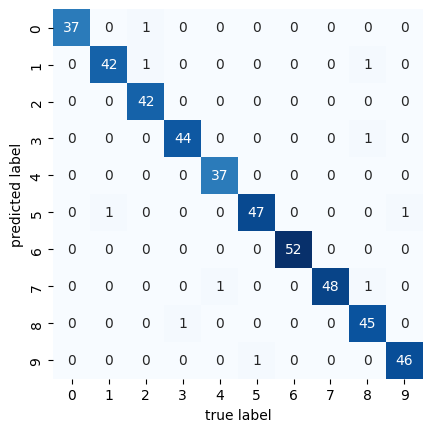

In [67]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d',
            cbar=False, cmap='Blues')
plt.xlabel('true label')
plt.ylabel('predicted label');

We find that a simple, untuned random forest results in a quite accurate classification of the digits data.

## Summary

This chapter provided a brief introduction to the concept of ensemble estimators, and in particular the random forest, an ensemble of randomized decision trees.
Random forests are a powerful method with several advantages:

- Both training and prediction are very fast, because of the simplicity of the underlying decision trees. In addition, both tasks can be straightforwardly parallelized, because the individual trees are entirely independent entities.
- The multiple trees allow for a probabilistic classification: a majority vote among estimators gives an estimate of the probability (accessed in Scikit-Learn with the `predict_proba` method).
- The nonparametric model is extremely flexible and can thus perform well on tasks that are underfit by other estimators.

A primary disadvantage of random forests is that the results are not easily interpretable: that is, if you would like to draw conclusions about the *meaning* of the classification model, random forests may not be the best choice.

# Homework

#### Problem 1.
Load the Iris dataset from sklearn,
```
from sklearn.datasets import load_iris
```
Following the example above, train a random forest classifier on the train sample and show accuracy on the test sample. Estimate and make a bar-plot of feature importances and interpret the ranking.

#### Problem 2.
Estimate and make a bar-plot of feature importances for the `digits` example above and interpret the ranking (just one/two lines for plotting is enough).

#### Problem 3.
Develop a random forest model to solve the classification problem of Project 3 using extracted input features of the LFP signal. Estimate and make a bar-plot of feature importances and interpret the results.

# Problem 1

Test Accuracy: 100.00%

Feature Importances:
  sepal length (cm): 0.104
  sepal width (cm): 0.045
  petal length (cm): 0.417
  petal width (cm): 0.434


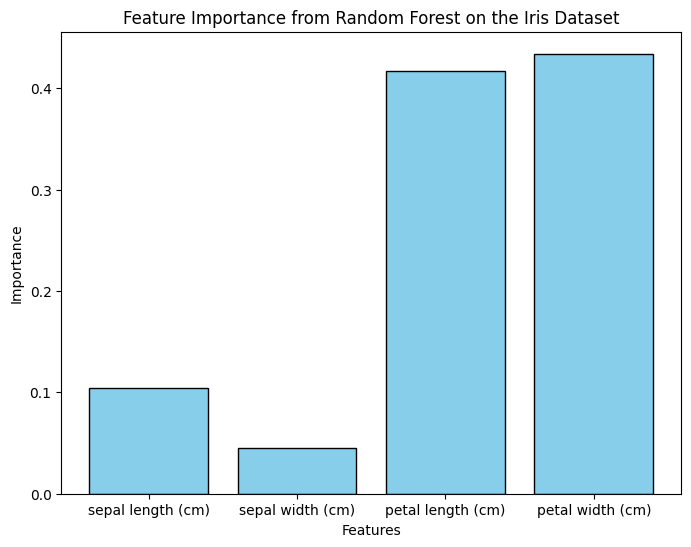

In [68]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

#Load the Iris dataset
iris = load_iris()
X = iris.data            # Features: sepal length, sepal width, petal length, petal width
y = iris.target          # Class labels: 0 (setosa), 1 (versicolor), 2 (virginica)


# Split the data into training and test samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Evaluate the classifier on the test set
accuracy = rf.score(X_test, y_test)
print("Test Accuracy: {:.2f}%".format(accuracy * 100))

# Extract feature importances from the trained model
importances = rf.feature_importances_
print("\nFeature Importances:")
for feature_name, importance in zip(iris.feature_names, importances):
    print(f"  {feature_name}: {importance:.3f}")


plt.figure(figsize=(8, 6))
plt.bar(iris.feature_names, importances, color='skyblue', edgecolor='k')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance from Random Forest on the Iris Dataset')
plt.show()

This chart confirms that petal length and petal width are the most important predictors,
indicating they are crucial for distinguishing between Iris setosa, versicolor, and virginica.

# Problem 2

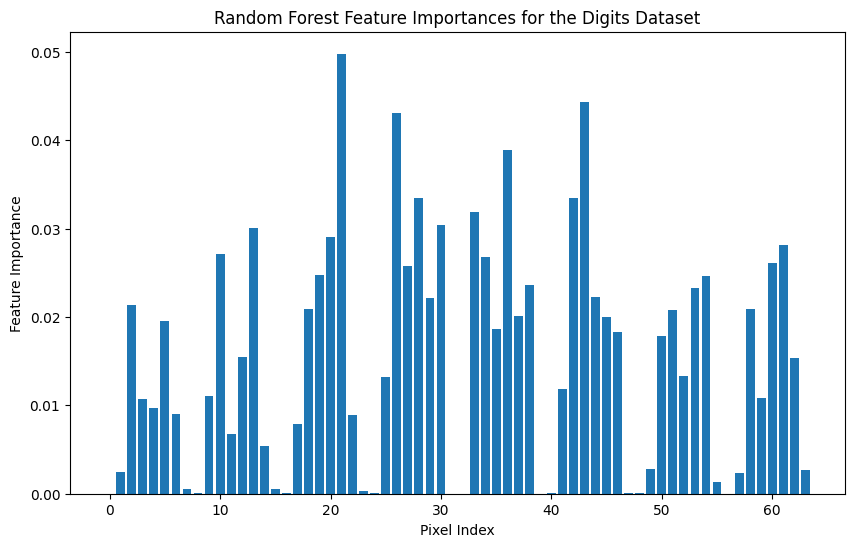

In [69]:
# Load the digits dataset
digits = load_digits()

# Split the data into training and test sets
Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target, random_state=0)

# Create and train the RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=1000, random_state=0)
rf_model.fit(Xtrain, ytrain)

# Obtain the feature importances from the trained model
feature_importances = rf_model.feature_importances_

# Plot a bar chart of feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances)
plt.xlabel('Pixel Index')
plt.ylabel('Feature Importance')
plt.title('Random Forest Feature Importances for the Digits Dataset')
plt.show()

# Problem 3

In [70]:
# Code from my project3

import h5py
import numpy as np

# File paths for the three subjects
files = [
    "Rat08-20130711_017.h5",
    "Part1SubjectHB10.h5",
    "Part2SubjectHB13.h5"
]

# Define subject names corresponding to each file
subject_names = ["Rat08_HPC", "SubjectHB10_BLA", "SubjectHB13_BLA"]

data_dict = {}

for subject, filename in zip(subject_names, files):
    segments, labels = [], []
    with h5py.File(filename, 'r') as f:
        fs = f.attrs.get('fs', 1250)
        for state in f.keys():
            lab = 1 if state == "NREM" else 0
            for seg in f[state].values():
                segments.append(seg[()].astype(float))
                labels.append(lab)
    data_dict[subject] = {"segments": segments, "labels": np.array(labels), "fs": fs}
    print(f"{subject}: Loaded {len(segments)} segments")

clip_duration = 5  #seconds
processed_data = {}

for subject in subject_names:
    fs = data_dict[subject]["fs"] if "fs" in data_dict[subject] else 1250 # default
    clip_length = int(clip_duration * fs)
    X_clips = []
    y_clips = []

    segs = data_dict[subject]["segments"]
    labs = data_dict[subject]["labels"]
    for seg, lab in zip(segs, labs):
        if len(seg) < clip_length:
            continue
        n_clips = len(seg) // clip_length
        # Only use full clips
        seg_clips = seg[:n_clips * clip_length].reshape(n_clips, clip_length)
        for clip in seg_clips:
            X_clips.append(clip)
        y_clips.extend([lab] * n_clips)

    X_clips = np.array(X_clips)
    y_clips = np.array(y_clips)
    print(f"{subject}: total {len(X_clips)} clips ({sum(y_clips==1)} NREM, {sum(y_clips==0)} WAKE).")
    processed_data[subject] = {"X": X_clips, "y": y_clips, "fs": fs}

from scipy.signal import welch
from scipy.stats import skew, kurtosis

# Define frequency bands
# used from here https://www.researchgate.net/post/What-is-the-basic-knowledge-or-assumption-to-the-classification-of-brain-wave-rhythm-delta-theta-alpha-beta-gamma-bands#:~:text=delta%280.5
bands = {
    "delta": (0.5, 4), #hz
    "theta": (4, 8),
    "alpha": (8, 13),
    "beta":  (13, 30),
    "gamma": (30, 100)
}


#Using Welch's method from here https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html
for subject in subject_names:
    X_clips = processed_data[subject]["X"]
    fs = processed_data[subject]["fs"]
    features = []
    for clip in X_clips:

        mu = np.mean(clip)
        sigma = np.std(clip)
        sk_val = skew(clip)
        ku_val = kurtosis(clip)

        freqs, psd = welch(clip, fs, nperseg=256)
        band_powers = []
        for low, high in bands.values():
            mask = (freqs >= low) & (freqs < high)
            power = np.trapezoid(psd[mask], freqs[mask]) if np.any(mask) else 0
            band_powers.append(power)
        features.append([mu, sigma, sk_val, ku_val] + band_powers)
    features = np.array(features)
    processed_data[subject]["features"] = features
    print(f"{subject}: Extracted features shape = {features.shape}")

import matplotlib.pyplot as plt
import seaborn as sns

# Example: PSD plot for one NREM clip vs. one WAKE clip from "Rat08_HPC"
fs = processed_data["Rat08_HPC"]["fs"]
# Assuming the first clip is NREM and the last clip is WAKE (based on original ordering)
example_nrem_clip = processed_data["Rat08_HPC"]["X"][0]
example_wake_clip = processed_data["Rat08_HPC"]["X"][-1]
freqs_n, psd_n = welch(example_nrem_clip, fs, nperseg=256)
freqs_w, psd_w = welch(example_wake_clip, fs, nperseg=256)




from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

splits = {}

for subject in subject_names:
    X = processed_data[subject]["features"]
    y = processed_data[subject]["y"]
    # Split: Train+Val and Test
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=0.15, random_state=42, stratify=y)
    # Further split Train+Val into Train and Validation
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=0.15/0.85, random_state=42, stratify=y_train_val)
    # Normalize using training set statistics only
    scaler = StandardScaler().fit(X_train)
    X_train_sc = scaler.transform(X_train)
    X_val_sc   = scaler.transform(X_val)
    X_test_sc  = scaler.transform(X_test)
    splits[subject] = {
        "X_train": X_train_sc, "y_train": y_train,
        "X_val": X_val_sc,     "y_val": y_val,
        "X_test": X_test_sc,   "y_test": y_test
    }
    print(f"{subject}: Train={len(y_train)}, Val={len(y_val)}, Test={len(y_test)} clips")



Rat08_HPC: Loaded 96 segments
SubjectHB10_BLA: Loaded 55 segments
SubjectHB13_BLA: Loaded 41 segments
Rat08_HPC: total 3682 clips (1239 NREM, 2443 WAKE).
SubjectHB10_BLA: total 907 clips (330 NREM, 577 WAKE).


<ipython-input-70-d37b659d8442>:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  clip_length = int(clip_duration * fs)


SubjectHB13_BLA: total 913 clips (295 NREM, 618 WAKE).
Rat08_HPC: Extracted features shape = (3682, 9)
SubjectHB10_BLA: Extracted features shape = (907, 9)
SubjectHB13_BLA: Extracted features shape = (913, 9)
Rat08_HPC: Train=2576, Val=553, Test=553 clips
SubjectHB10_BLA: Train=634, Val=136, Test=137 clips
SubjectHB13_BLA: Train=639, Val=137, Test=137 clips



=== Random Forest for subject: Rat08_HPC ===
Validation Accuracy: 92.59%
Test Accuracy: 92.22%


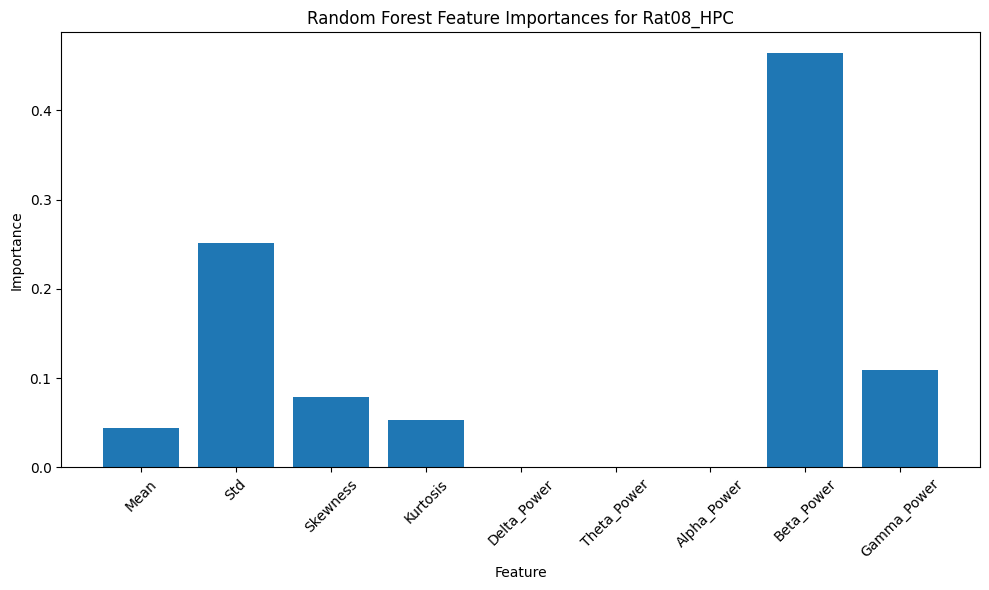


=== Random Forest for subject: SubjectHB10_BLA ===
Validation Accuracy: 100.00%
Test Accuracy: 100.00%


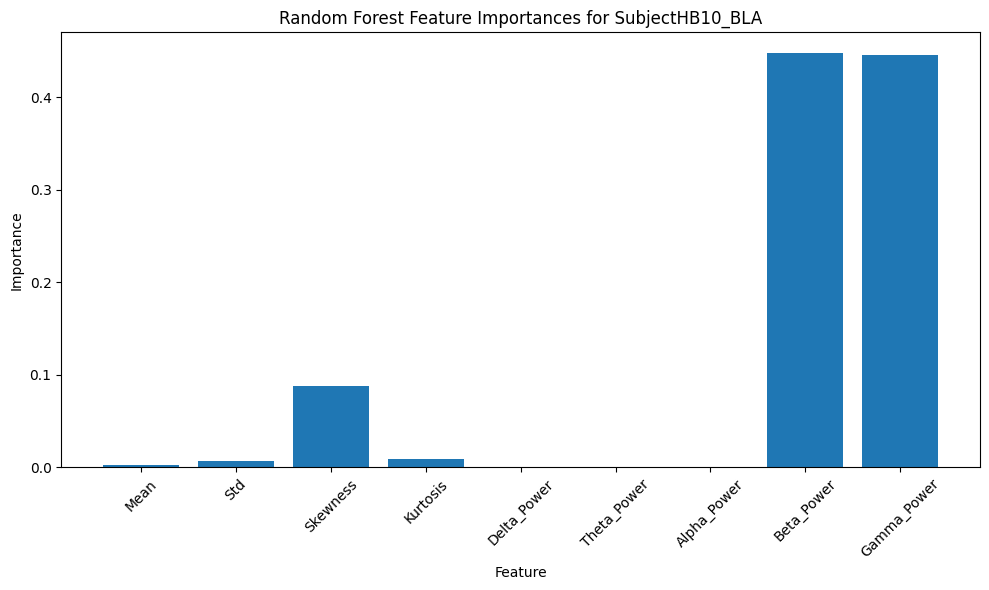


=== Random Forest for subject: SubjectHB13_BLA ===
Validation Accuracy: 100.00%
Test Accuracy: 99.27%


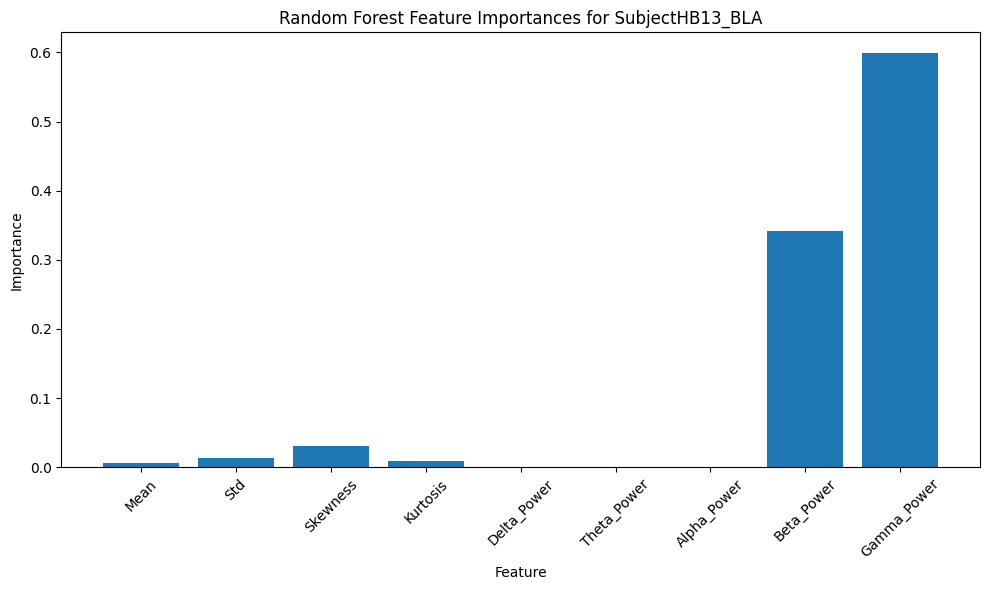

In [71]:
# CELL X: Random Forest Classification with Bar Plot Feature Importances

feature_names = ["Mean", "Std", "Skewness", "Kurtosis",
                 "Delta_Power", "Theta_Power", "Alpha_Power", "Beta_Power", "Gamma_Power"]

rf_models = {}

for subject in subject_names:
    print(f"\n=== Random Forest for subject: {subject} ===")

    # Retrieve the normalized splits
    X_train = splits[subject]["X_train"]
    y_train = splits[subject]["y_train"]
    X_val   = splits[subject]["X_val"]
    y_val   = splits[subject]["y_val"]
    X_test  = splits[subject]["X_test"]
    y_test  = splits[subject]["y_test"]

    # Initialize and train the Random Forest classifier
    rf = RandomForestClassifier(n_estimators=1000, random_state=0)
    rf.fit(X_train, y_train)

    # Evaluate the classifier on validation and test sets
    y_val_pred = rf.predict(X_val)
    val_acc = accuracy_score(y_val, y_val_pred)
    print(f"Validation Accuracy: {val_acc * 100:.2f}%")

    y_test_pred = rf.predict(X_test)
    test_acc = accuracy_score(y_test, y_test_pred)
    print(f"Test Accuracy: {test_acc * 100:.2f}%")


    feature_importances = rf.feature_importances_

    # Plot a bar chart of the feature importances
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(feature_importances)), feature_importances)
    plt.xticks(range(len(feature_importances)), feature_names, rotation=45)
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.title(f"Random Forest Feature Importances for {subject}")
    plt.tight_layout()
    plt.show()

Beta and gamma power are the most important features for classifying the sleep states. Beta power is very important for all subjects and gamma power is especially important for SubjectHB10_BLA and SubjectHB13_BLA. The measures like mean and the power in the delta theta and alpha bands are not very useful. It shows that the higher frequency features help distinguish between NREM and WAKE states better than the basic statistics like mean and standard deviation